In [24]:
#importing necessary modules
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import random
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu,SmoothingFunction
import re
import torch.nn.functional as F


In [3]:
model_checkpoint="attention_language_translation.pth"

In [5]:
df=pd.read_csv('/kaggle/input/nepali-english/npi.txt',delimiter='\t', names=['English','Nepali','Att'])
df.drop(columns=['Att'],inplace=True)
df.head()

,English,Nepali
0,Who?,को?
1,Hide.,लुकाउनुहोस्।
2,Hide.,लुक।
3,Stay.,बस्नुहोस्।
4,Hello!,नमस्ते!


In [6]:
# Function to add spaces around punctuation
def tokenize_sentence(sentence):
    # Regular expression to add space around punctuation
    sentence = re.sub(r'([,.!?।])', r' \1 ', sentence)
    # Removing extra spaces
    sentence = re.sub(r'\s+', ' ', sentence).strip()
    return sentence

df['English']=df['English'].apply(tokenize_sentence)
df["Nepali"]=df['Nepali'].apply(tokenize_sentence)

In [7]:
df.shape

(2689, 2)

In [8]:
df.head()

,English,Nepali
0,Who ?,को ?
1,Hide .,लुकाउनुहोस् ।
2,Hide .,लुक ।
3,Stay .,बस्नुहोस् ।
4,Hello !,नमस्ते !


Creating vocabulary for english

In [9]:
#getting all tokens for english

#Add SOS and EOS tokens to the Nepali vocabulary
english_vocab = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2} 

tokens_english = [token for x in df['English'] for token in x.split()]

#make the token_counter in order to count the number of times the token appearred in the enitre document
token_counter_english = Counter(tokens_english)

# Create the vocabulary dictionary
english_vocab.update({token: idx + 3 for idx, token in enumerate(token_counter_english)})

In [10]:
len(english_vocab)

2178

Creating vocabulary for Nepali

In [11]:
df['Nepali']='<SOS>' + " " + df['Nepali'] + " " +  '<EOS>'

In [12]:
#Add SOS and EOS tokens to the Nepali vocabulary
nepali_vocab = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2} 

# Getting all tokens for Nepali and excluding SOS and EOS tokens
tokens_nepali = [token for x in df['Nepali'] for token in x.split() if token not in ['<SOS>', '<EOS>']]

# Make the token_counter to count the number of times the token appeared in the entire document
token_counter_nepali = Counter(tokens_nepali)

# Update the vocabulary dictionary with other tokens
# Update the vocabulary dictionary with other tokens
nepali_vocab.update({token: idx + 3 for idx, token in enumerate(token_counter_nepali)})


In [13]:
len(nepali_vocab)

3087

In [14]:
# Convert text to sequences using the vocabulary dictionary
df['encoded_english'] = df['English'].apply(lambda x: [english_vocab[token] for token in x.split()])
df['encoded_nepali'] = df['Nepali'].apply(lambda x: [nepali_vocab[token] for token in x.split()])

# Convert sequences to tensors and only select the sequence by truncating it to max_length of 20
max_length = 20
padding_index = 2  # Index of <PAD> token
padded_sequences_english = [seq[:max_length] if len(seq) >= max_length else seq + [padding_index] * (max_length - len(seq)) for seq in df['encoded_english']]
padded_sequences_nepali = [seq[:max_length] if len(seq) >= max_length else seq + [padding_index] * (max_length - len(seq)) for seq in df['encoded_nepali']]

# Convert the padded sequences to tensors
df['padded_sequence_english'] = padded_sequences_english
df['padded_sequence_nepali'] = padded_sequences_nepali


In [15]:
df.head()

,English,Nepali,encoded_english,encoded_nepali,padded_sequence_english,padded_sequence_nepali
0,Who ?,<SOS> को ? <EOS>,"[3, 4]","[0, 3, 4, 1]","[3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 3, 4, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
1,Hide .,<SOS> लुकाउनुहोस् । <EOS>,"[5, 6]","[0, 5, 6, 1]","[5, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 5, 6, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
2,Hide .,<SOS> लुक । <EOS>,"[5, 6]","[0, 7, 6, 1]","[5, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 7, 6, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
3,Stay .,<SOS> बस्नुहोस् । <EOS>,"[7, 6]","[0, 8, 6, 1]","[7, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 8, 6, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,Hello !,<SOS> नमस्ते ! <EOS>,"[8, 9]","[0, 9, 10, 1]","[8, 9, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0, 9, 10, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."


In [16]:

# Convert 'padded_sequence' to a tensor
padded_sequences_english = torch.tensor(df['padded_sequence_english'].tolist())
padded_sequences_nepali = torch.tensor(df['padded_sequence_nepali'].tolist())

# Train-test split
train_sequences_english, test_sequences_english, train_sequences_nepali, test_sequences_nepali = train_test_split(
    padded_sequences_english, padded_sequences_nepali, test_size=0.2, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(train_sequences_english, train_sequences_nepali)
test_dataset = TensorDataset(test_sequences_english, test_sequences_nepali)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,drop_last=True)

# CREATING THE MODEL

In [17]:
class Encoder(nn.Module):
    
    
    """
    Encoder class for a sequence-to-sequence model with an LSTM architecture.

    Args:
        input_size (int): Size of the input vocabulary.
        embedding_size (int): Dimension of the embeddings.
        hidden_size (int): Number of features in the hidden state of the LSTM.
        num_layers (int): Number of recurrent layers in the LSTM.
        p (float): Dropout probability.

    Attributes:
        dropout (nn.Dropout): Dropout layer.
        hidden_size (int): Number of features in the hidden state of the LSTM.
        num_layers (int): Number of recurrent layers in the LSTM.
        embedding (nn.Embedding): Embedding layer that converts input tokens to embeddings.
        lstm (nn.LSTM): LSTM layer for encoding the input sequence.

    Methods:
        forward(x):
            Forward pass through the encoder.
            Args:
                x (torch.Tensor): Input tensor of shape (N, seq_length), where N is the batch size.
            Returns:
                tuple: Tuple containing the hidden state and cell state from the LSTM.
    """
        
    def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
        super(Encoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, dropout=p,batch_first=True)

    def forward(self, x):
        # x shape: (N,seq_length) where N is batch size
        embedding = self.dropout(self.embedding(x))
        # embedding shape: (N,seq_length, embedding_size)

        outputs, (hidden, cell) = self.lstm(embedding)
        # outputs shape: (N,seq_length, hidden_size)

        return outputs,hidden, cell


In [18]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

In [19]:
class Decoder(nn.Module):
    
    """
    Decoder module for sequence-to-sequence model.

    Args:
        input_size (int): Size of the input vocabulary.
        embedding_size (int): Size of the word embeddings.
        hidden_size (int): Size of the hidden states in the LSTM.
        output_size (int): Size of the output vocabulary.
        num_layers (int): Number of layers in the LSTM.
        p (float): Dropout probability.

    Attributes:
        dropout (torch.nn.Dropout): Dropout layer.
        hidden_size (int): Size of the hidden states in the LSTM.
        num_layers (int): Number of layers in the LSTM.
        attention (BahdanauAttention): Attention mechanism.
        embedding (torch.nn.Embedding): Embedding layer.
        lstm (torch.nn.LSTM): LSTM layer.
        fc (torch.nn.Linear): Fully connected layer for output.
    """
    def __init__(
        self, input_size, embedding_size, hidden_size, output_size, num_layers, p
    ):
        super(Decoder, self).__init__()
        self.dropout = nn.Dropout(p)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = BahdanauAttention(embedding_size)
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.lstm = nn.LSTM(2 * embedding_size, hidden_size, num_layers, dropout=p,batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell,enc_output):
#         print("x shape for decoder",x.shape)
        # x shape: (N) where N is for batch size, we want it to be (N,1), seq_length
        # is 1 here because we are sending in a single word and not a sentence
        x = x.unsqueeze(1)
        #after unsqueeze it becomes [64,1], where 64 is batch size

        embedding = self.dropout(self.embedding(x))
#         print("embedding shape,hello",embedding.shape,hidden.shape, cell.shape)
        # embedding shape: (N,1, embedding_size)
#         print("hidden and cell size in decoder",hidden.size,cell.size)
        query=hidden[-1,:,:].unsqueeze(0).permute(1,0,2)
        
        context,attn_weights=self.attention(query,enc_output)
        
        input_lstm=torch.cat((embedding,context),dim=2)
        
        outputs, (hidden, cell) = self.lstm(input_lstm, (hidden, cell))
        # outputs shape: (N,1, hidden_size)
        
        predictions = self.fc(outputs)
#         print("predictions shape is " ,predictions.shape)

        # predictions shape: (N,1, length_target_vocabulary) to send it to
        # loss function we want it to be (N, length_target_vocabulary) so we're
        # just gonna remove the first dim
        predictions = predictions.squeeze(1)
        
    
        
        return predictions, hidden, cell


In [20]:
class Seq2Seq(nn.Module):
    
    
    """
    Sequence-to-Sequence (Seq2Seq) model composed of an encoder and a decoder.

    Args:
        encoder (nn.Module): Encoder module.
        decoder (nn.Module): Decoder module.

    Attributes:
        encoder (nn.Module): Encoder module.
        decoder (nn.Module): Decoder module.

    Methods:
        forward(source, target):
            Forward pass through the Seq2Seq model.
            Args:
                source (torch.Tensor): Source input tensor.
                target (torch.Tensor): Target input tensor.
            Returns:
                torch.Tensor: Output tensor from the Seq2Seq model.
    """
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_force_ratio=0.5):

        batch_size = source.shape[0]
        target_len = target.shape[1]

        target_vocab_size = len(nepali_vocab)

        outputs = torch.zeros(batch_size,target_len, target_vocab_size).to(device)

        enc_output,hidden, cell = self.encoder(source)

        # Grab the first input to the Decoder which will be <SOS> token
        
        x = target[:,0]

        for t in range(1, target_len):
            # Use previous hidden, cell as context from encoder at start

            
            output, hidden, cell = self.decoder(x, hidden, cell,enc_output)

            
            # Store next output prediction
            outputs[:,t,:] = output


            #directly sending the ground truth for next input
            x = target[:,t] 

        return outputs
    


In [21]:
# Training hyperparameters
num_epochs = 100
learning_rate = 0.001
batch_size = 64

# Model hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size_encoder = len(english_vocab)
input_size_decoder = len(nepali_vocab)
output_size = len(nepali_vocab)
encoder_embedding_size = 300
decoder_embedding_size = 300
hidden_size = 300 
num_layers = 2
enc_dropout = 0.3
dec_dropout = 0.3

In [22]:
encoder_net = Encoder(input_size_encoder, encoder_embedding_size, hidden_size, num_layers, enc_dropout).to(device)

decoder_net = Decoder(
    input_size_decoder,
    decoder_embedding_size,
    hidden_size,
    output_size,
    num_layers,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define the loss function
criterion = nn.CrossEntropyLoss(ignore_index=padding_index)

In [23]:
# Training loop
epochs=[]
losses=[]
for epoch in range(num_epochs):
    epochs.append(epoch)
    total_loss = 0

    # Set the model to train mode
    model.train()

    for batch_idx, (source, target) in enumerate(train_loader):
        # Move tensors to device
        source = source.to(device)
        target = target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        
        # Forward pass
        output = model(source, target)
        output = output.permute(0,2,1)

        
        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()
        
        # Save the model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_checkpoint)

        total_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader)}')
    
    mean_loss=total_loss/len(train_loader)
    losses.append(mean_loss)
    
    



Epoch [1/100], Loss: 6.235218394886363
Epoch [2/100], Loss: 5.398127122358843
Epoch [3/100], Loss: 5.250487905560118
Epoch [4/100], Loss: 5.135353940905946
Epoch [5/100], Loss: 5.018959507797703
Epoch [6/100], Loss: 4.897664720361883
Epoch [7/100], Loss: 4.776387200211033
Epoch [8/100], Loss: 4.671327128554836
Epoch [9/100], Loss: 4.567252029072154
Epoch [10/100], Loss: 4.463956139304421
Epoch [11/100], Loss: 4.351000251192035
Epoch [12/100], Loss: 4.2359740228363965
Epoch [13/100], Loss: 4.129506277315544
Epoch [14/100], Loss: 4.028208407488736
Epoch [15/100], Loss: 3.93636374762564
Epoch [16/100], Loss: 3.8397983998963325
Epoch [17/100], Loss: 3.746422478646943
Epoch [18/100], Loss: 3.645580356771296
Epoch [19/100], Loss: 3.552450252301765
Epoch [20/100], Loss: 3.46660819198146
Epoch [21/100], Loss: 3.380581321138324
Epoch [22/100], Loss: 3.282433350880941
Epoch [23/100], Loss: 3.191561641115131
Epoch [24/100], Loss: 3.1061865922176475
Epoch [25/100], Loss: 3.0244560169451162
Epoch [

NameError: name 'plt' is not defined

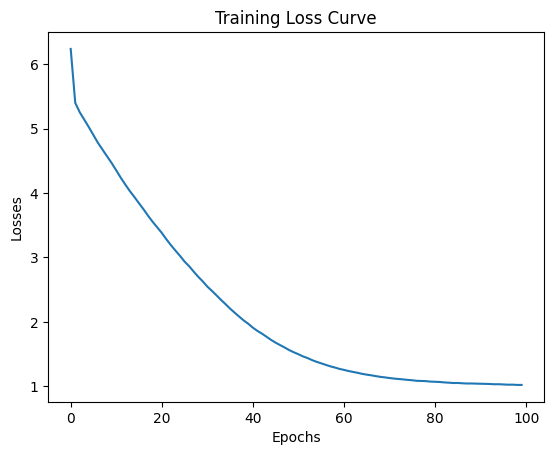

In [25]:
# Plotting the training loss curve
plt.plot(epochs, losses)
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Training Loss Curve')
plt.show()


In [26]:
# Evaluation function
def evaluate(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for source, target in test_loader:
            # Move tensors to device
            source = source.to(device)
            target = target.to(device)

            # Forward pass
            output = model(source, target)

            # Reshape output to match the target shape
            output = output.reshape(-1, output.shape[-1])
            target = target.reshape(-1)

            # Calculate the loss
            loss = criterion(output, target)
            total_loss += loss.item()


    # Calculate average loss and accuracy
    avg_loss = total_loss / len(test_loader)
    

    return avg_loss

# Evaluate the model on the test dataset
test_loss = evaluate(model, test_loader, criterion)

# Print the test loss and accuracy
print(f'Test Loss: {test_loss}')


Test Loss: 5.381843149662018


In [30]:
# Function to decode a sequence of tokens using the vocabulary
def decode_sequence(sequence, vocab):
    # Invert the vocabulary dictionary
    inv_vocab = {v: k for k, v in vocab.items()}
    
    decoded_tokens = []
    for token in sequence:

        token_id = token.item()
        if token_id == 2:  # Padding token
            break
        elif token_id == 0:  # SOS token
            continue
        elif token_id == 1:  # EOS ।token
            break
        else:
            # Fallback for unknown tokens
            decoded_tokens.append(inv_vocab.get(token_id, f"<unk:{token_id}>"))
    return ' '.join(decoded_tokens)


# Choose a random index from the test dataset
for i in range(1,100):
    index = i # You can change this to any index you want to check

    # Get the source and target sequences for the chosen index
    source_sequence = test_dataset[index][0].unsqueeze(0).to(device)
    # print(source_sequence)
    target_sequence = test_dataset[index][1].unsqueeze(0).to(device)


    # Forward pass
    model.eval()
    with torch.no_grad():


        output = model(source_sequence, target_sequence)


        output = output.squeeze(1)  

        predicted_indices = output.argmax(2).squeeze(0)  

    #     print(predicted_indices.shape)

        # Decode the predicted sequence
        predicted_translation = decode_sequence(predicted_indices, nepali_vocab)

        # Get the actual target sequence and decode it
        actual_translation = decode_sequence(target_sequence.squeeze(), nepali_vocab)


    # Invert the vocabulary dictionary
    eng_inv_vocab = {v: k for k, v in english_vocab.items()}

    # print(eng_inv_vocab)
    eng_decoded=[]
    for engtoken in source_sequence.squeeze(0):
        if engtoken != 2:
            eng_decoded.append(eng_inv_vocab.get(engtoken.item(), f"<unk:{engtoken}>"))

    
    
    # Initialize the smoothing function
    smoothing_function = SmoothingFunction().method1
    score = sentence_bleu([actual_translation.split()],predicted_translation.split(), smoothing_function=smoothing_function)
    
    #print the results having bluescore greather than 0.3
    if score>0.3:
    
        # Print the actual and predicted translations
        print("-----------------------")
        print(f'Actual English Sentence : ', ' '.join(eng_decoded))
        print(f'Actual Translation: {actual_translation}')
        print(f'Predicted Translation: {predicted_translation}')
        print("BLEU score is : ",score)
        print("------------------------")

-----------------------
Actual English Sentence :  I'm very grateful to you .
Actual Translation: म तपाईप्रति धेरै आभारी छु ।
Predicted Translation: म तपाईप्रति धेरै आभारी छु ।
BLEU score is :  1.0
------------------------
-----------------------
Actual English Sentence :  Take him to the hospital .
Actual Translation: उहाँलाई अस्पताल लैजानुहोस् ।
Predicted Translation: उसलाई अस्पताल लैजानुहोस् ।
BLEU score is :  0.3976353643835253
------------------------
-----------------------
Actual English Sentence :  I don't want to leave you .
Actual Translation: म तिमीलाई छोड्न चाहन्न ।
Predicted Translation: म तिमीलाई छोड्न चाहन्न ।
BLEU score is :  1.0
------------------------
-----------------------
Actual English Sentence :  I really liked your story .
Actual Translation: मलाई तपाईको कथा साँच्चै मन पर्यो ।
Predicted Translation: मलाई तिम्रो कथा साँच्चै मन पर्यो ।
BLEU score is :  0.6434588841607617
------------------------
-----------------------
Actual English Sentence :  You're feeling ve